Observations: \
    1. As the database provided are very limited, the data accuracy might be affected \
    2. As it's varous occupation, the data might be even splitted due to nature of occupation risk \
    3. As it's various country, the data might be splitted down to the enviroment risk

# 1. Import Libraries and Database

In [1]:
# Importing all the necessary libraries
 
import pandas as pd
import sqlite3 as db
import numpy as np

from datetime import datetime

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:

# Specify the file path or URL of the CSV file
file_path = "cardio_data.csv"  # Replace with the actual file path or URL

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df.head()


,date,country,id,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,occupation,smoke,weight,disease
0,03-05-2021,Indonesia,0,1,18393,0,110,80,1,2,1,168,Architect,0,62.0,0
1,05-08-2021,Malaysia,1,1,20228,0,140,90,3,1,1,156,Accountant,0,85.0,1
2,13-11-2022,Indonesia,2,0,18857,0,130,70,3,1,1,165,Chef,0,64.0,1
3,31-10-2018,Singapore,3,1,17623,0,150,100,1,2,1,169,Lawyer,0,82.0,1
4,25-09-2020,Singapore,4,0,17474,0,100,60,1,1,1,156,Architect,0,56.0,0


In [3]:
# Age is wrong, should be in years instead of days.
# Gender should be male or female, it's unclcear if 1 is female or male
# the height should be in cm, not in days

In [4]:
df.nunique()

date            1827
country            4
id             70000
active             2
age             8076
alco               2
ap_hi            153
ap_lo            157
cholesterol        3
gender             2
gluc               3
height           109
occupation         9
smoke              2
weight           287
disease            2
dtype: int64

In [5]:
df.describe()

,id,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight,disease
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,0.803729,19468.865814,0.053771,128.817286,96.630414,1.366871,1.349571,1.226457,164.359229,0.088129,74.205690,0.499700
std,28851.302323,0.397179,2467.251667,0.225568,154.011419,188.472530,0.680250,0.476838,0.572270,8.210126,0.283484,14.395757,0.500003
min,0.000000,0.000000,10798.000000,0.000000,-150.000000,-70.000000,1.000000,1.000000,1.000000,55.000000,0.000000,10.000000,0.000000
25%,25006.750000,1.000000,17664.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,159.000000,0.000000,65.000000,0.000000
50%,50001.500000,1.000000,19703.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,165.000000,0.000000,72.000000,0.000000
75%,74889.250000,1.000000,21327.000000,0.000000,140.000000,90.000000,2.000000,2.000000,1.000000,170.000000,0.000000,82.000000,1.000000
max,99999.000000,1.000000,23713.000000,1.000000,16020.000000,11000.000000,3.000000,2.000000,3.000000,250.000000,1.000000,200.000000,1.000000


# 2. PreProcessing

Correction: \
    - Date should be in datetime
    - For easy calculation, We can use the date of entry to add into the age for the current age
    - 

In [6]:
# Drop ID as we won't be using them
df.drop('id', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         70000 non-null  object 
 1   country      70000 non-null  object 
 2   active       70000 non-null  int64  
 3   age          70000 non-null  int64  
 4   alco         70000 non-null  int64  
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gender       70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  height       70000 non-null  int64  
 11  occupation   70000 non-null  object 
 12  smoke        70000 non-null  int64  
 13  weight       70000 non-null  float64
 14  disease      70000 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 8.0+ MB


# Date
- Changing to datetime
- Extracting the Year to new column

In [7]:
# Convert the 'Date' column to a datetime object
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Get the current date as a datetime object
current_date = datetime.now()

# Calculate the number of days elapsed for each date and store it in the 'DaysElapsed' column
df['days_elapsed'] = (current_date - df['date']).dt.days

# Display the updated DataFrame
print(df['days_elapsed'].head())

0     872
1     778
2     313
3    1787
4    1092
Name: days_elapsed, dtype: int64


# Age
   
- Calculate the "input" date
- Add into Age and divide by 365 to get the actual age

In [8]:
# Now we need to add it into the age and create the current age column
df['current_age'] = (df['age'] + df['days_elapsed']) / 365.25

# Display the updated DataFrame
print(df['current_age'].head())

0    52.744695
1    57.511294
2    52.484600
3    53.141684
4    50.830938
Name: current_age, dtype: float64


# Negative to Positive
There should be no negative blood pressure
- ap_hi
- ap_lo

In [9]:
# Convert ap_hi and ap_lo to absolute values
df['ap_hi'] = df['ap_hi'].abs()
df['ap_lo'] = df['ap_lo'].abs()

print(df['ap_hi'].head())
print(df['ap_lo'].head())

0    110
1    140
2    130
3    150
4    100
Name: ap_hi, dtype: int64
0     80
1     90
2     70
3    100
4     60
Name: ap_lo, dtype: int64


# Removing extreme outliers
- Humanly Systolic range is between 50 - 250
- Humanly diablolic range is between 50 - 200

In [10]:
# drop the ap_hi and ap_lo outliers
df = df[df['ap_hi'] < 250]
df = df[df['ap_hi'] > 50]
df = df[df['ap_lo'] < 120]
df = df[df['ap_lo'] > 50]

In [11]:
# drop the weight outliers
df = df[df['weight'] > 30]

# drop the height outliers
df = df[df['height'] > 130]

In [12]:
df.describe()

,date,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight,disease,days_elapsed,current_age
count,68296,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000,68296.000000
mean,2020-07-01 08:41:01.426730752,0.803283,19464.453614,0.053239,126.512182,81.217568,1.363682,1.348600,1.225269,164.451095,0.087897,74.086767,0.493733,1177.638178,56.514967
min,2018-01-01 00:00:00,0.000000,10798.000000,0.000000,70.000000,52.000000,1.000000,1.000000,1.000000,131.000000,0.000000,31.000000,0.000000,264.000000,31.255305
25%,2019-04-03 00:00:00,1.000000,17658.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,159.000000,0.000000,65.000000,0.000000,721.000000,51.603012
50%,2020-06-30 00:00:00,1.000000,19701.000000,0.000000,120.000000,80.000000,1.000000,1.000000,1.000000,165.000000,0.000000,72.000000,0.000000,1179.000000,57.136208
75%,2021-10-01 00:00:00,1.000000,21324.000000,0.000000,140.000000,90.000000,1.000000,2.000000,1.000000,170.000000,0.000000,82.000000,1.000000,1633.000000,61.932923
max,2023-01-01 00:00:00,1.000000,23713.000000,1.000000,240.000000,119.000000,3.000000,2.000000,3.000000,250.000000,1.000000,200.000000,1.000000,2090.000000,70.387406
std,NaN,0.397520,2468.291920,0.224511,16.382776,9.087140,0.678246,0.476531,0.571208,7.836914,0.283147,14.245748,0.499964,527.200076,6.921040


# Encoding Country and Occupation

In [13]:
# map country into Nominal Values
df['country'] = df['country'].map({'Singapore': 1, 'Malaysia': 2, 'Indonesia': 3, 'India': 4})

In [14]:
df['occupation'].unique()

array(['Architect', 'Accountant', 'Chef', 'Lawyer', 'Teacher', 'Nurse',
       'Engineer', 'Doctor', 'Others'], dtype=object)

In [15]:
# map Occupation into Nominal Values
df['occupation'] = df['occupation'].map({'Architect': 1, 'Accountant': 2, 'Chef': 3, 'Lawyer': 4, 'Teacher': 5, 'Nurse': 6, 'Engineer': 7, 'Doctor': 8, 'Others': 0})

In [16]:
# find out how many Chef is inside the Occupation column
df['occupation'].value_counts()

occupation
6    7737
2    7682
1    7669
0    7638
3    7533
4    7533
8    7517
7    7494
5    7493
Name: count, dtype: int64

# Visualize

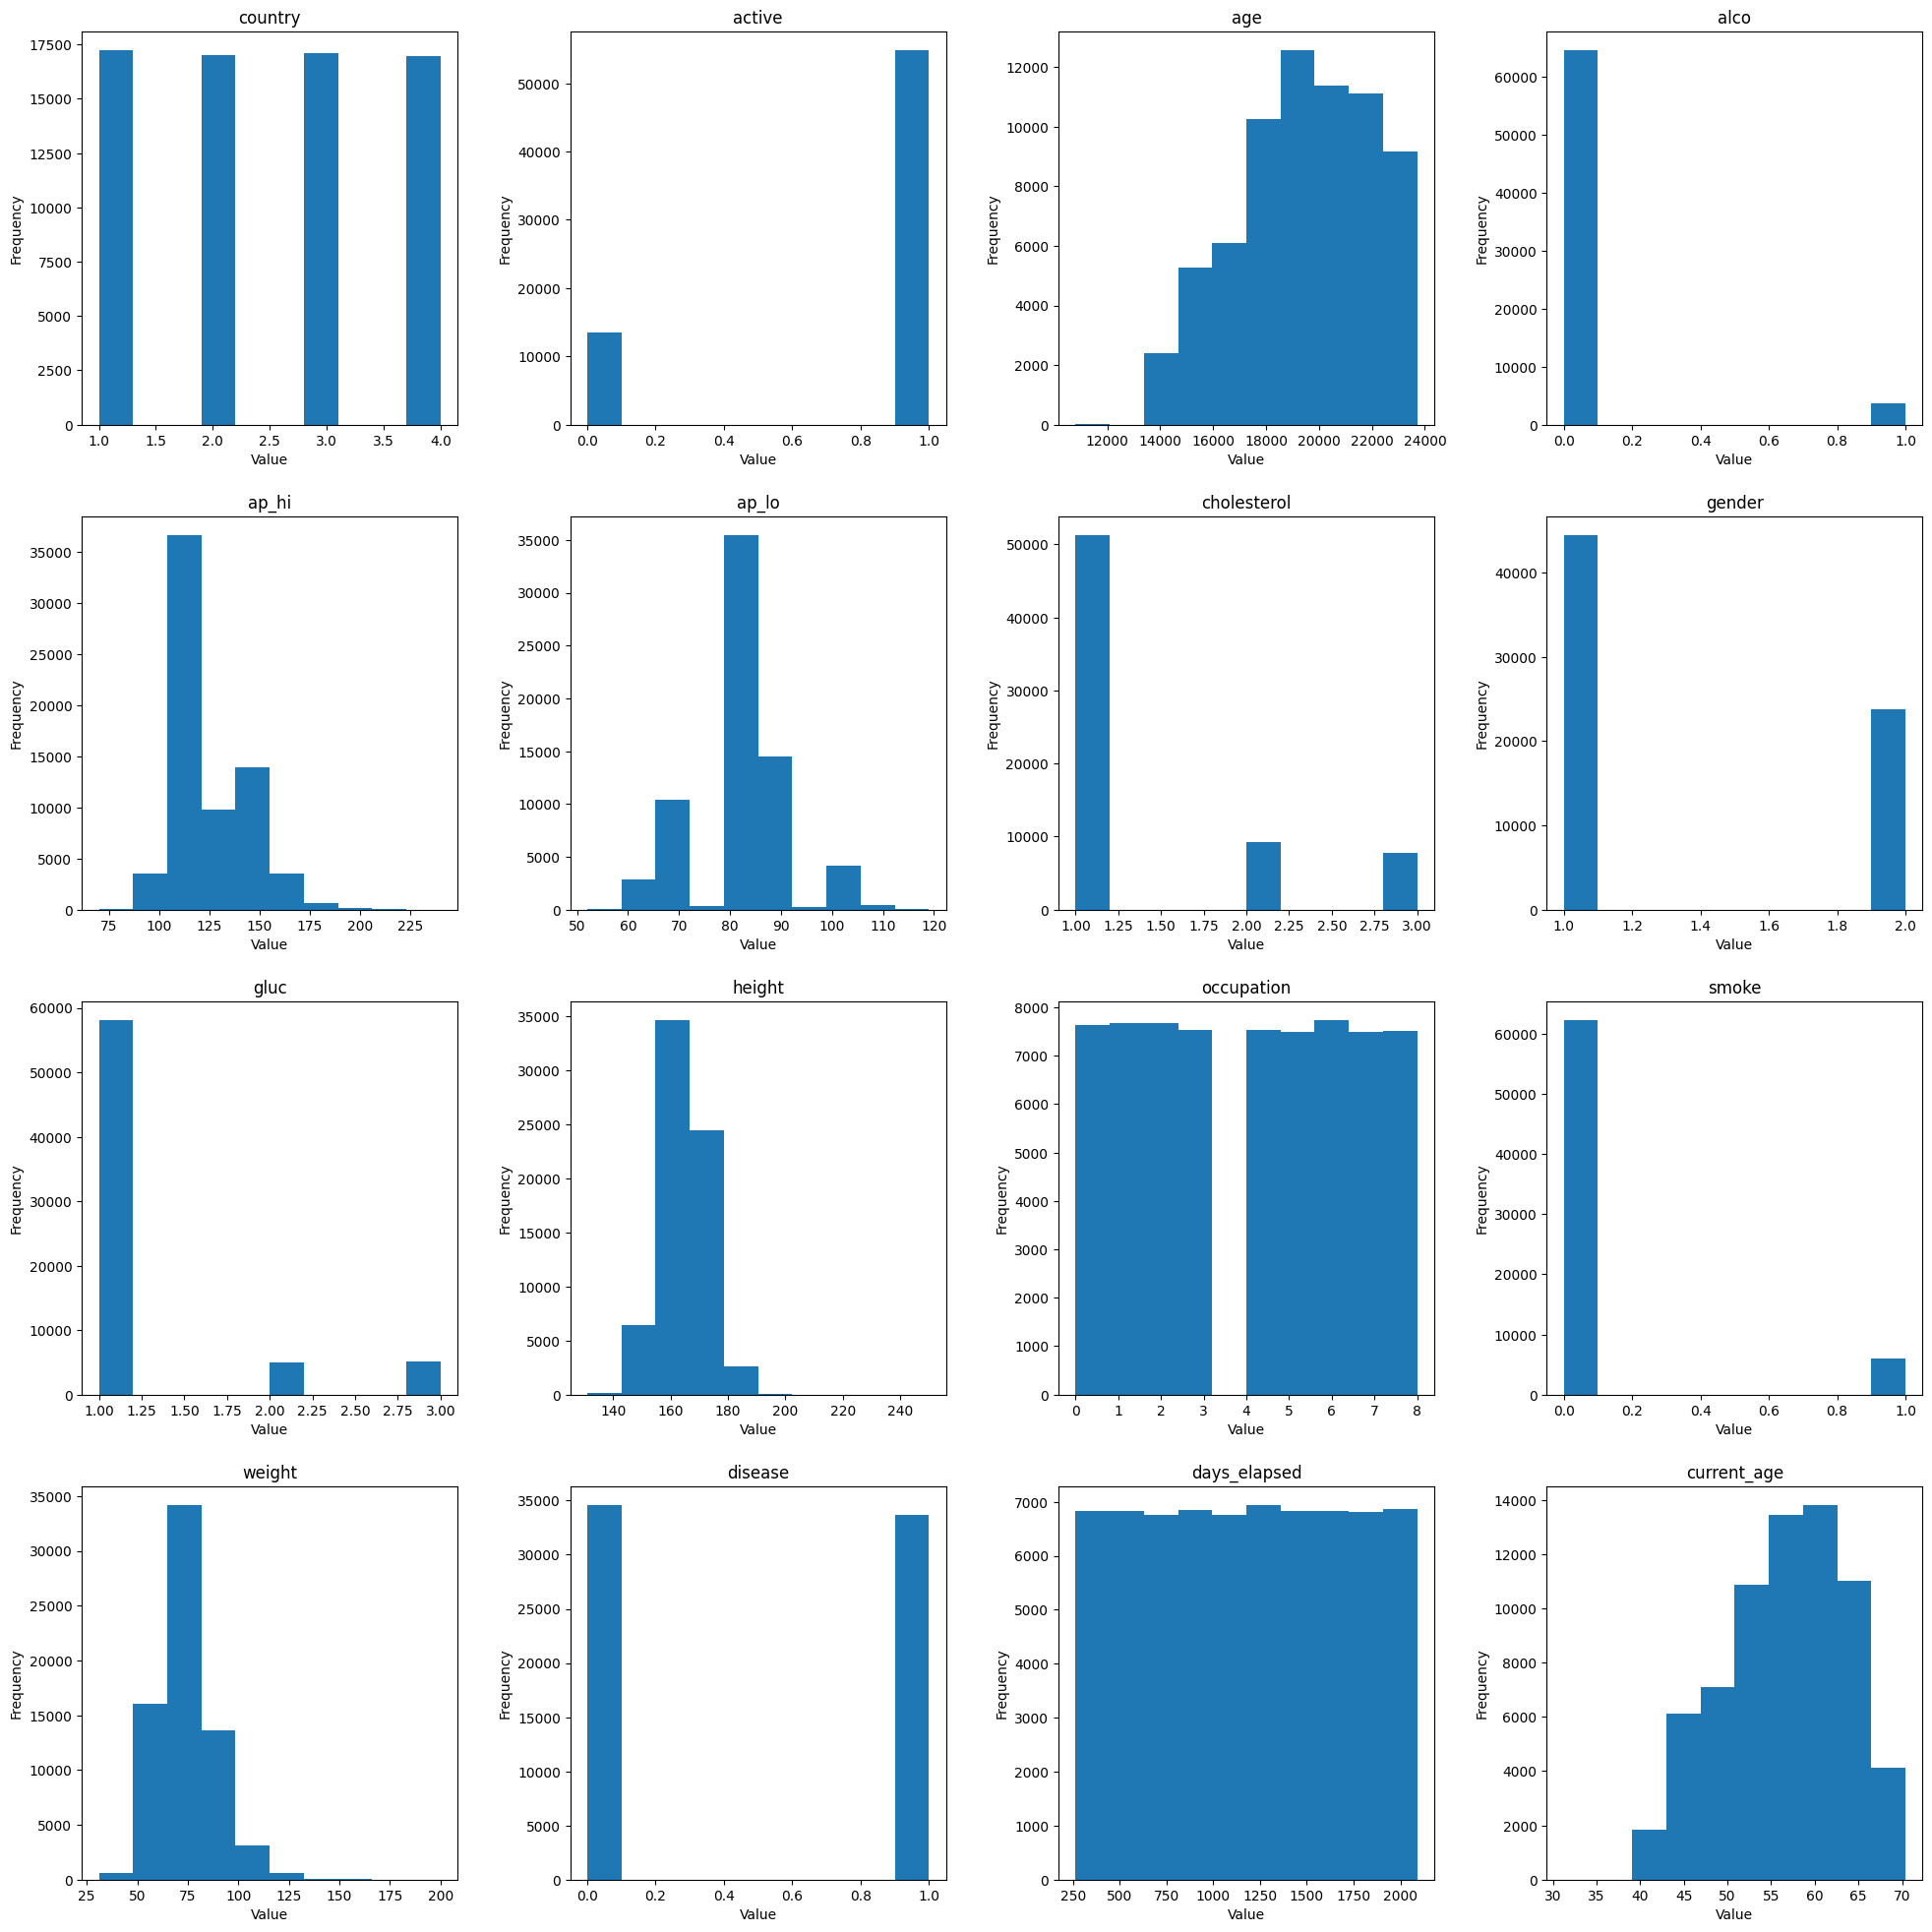

In [17]:
# Get the list of numerical column names
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# Create a 4 by 3 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# Loop through the numerical columns and generate histograms
for i, column in enumerate(numerical_columns):
    row, col = divmod(i, 4)  # Calculate row and column indices
    ax = axes[row, col]  # Get the current subplot
    df[column].plot(kind='hist', ax=ax, title=column)  # Generate histogram
    ax.set_xlabel('Value')  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label

# Adjust the spacing between subplots with tight_layout
plt.tight_layout(pad=2)  # Increase the pad value to increase spacing

# Show the plots
plt.show()

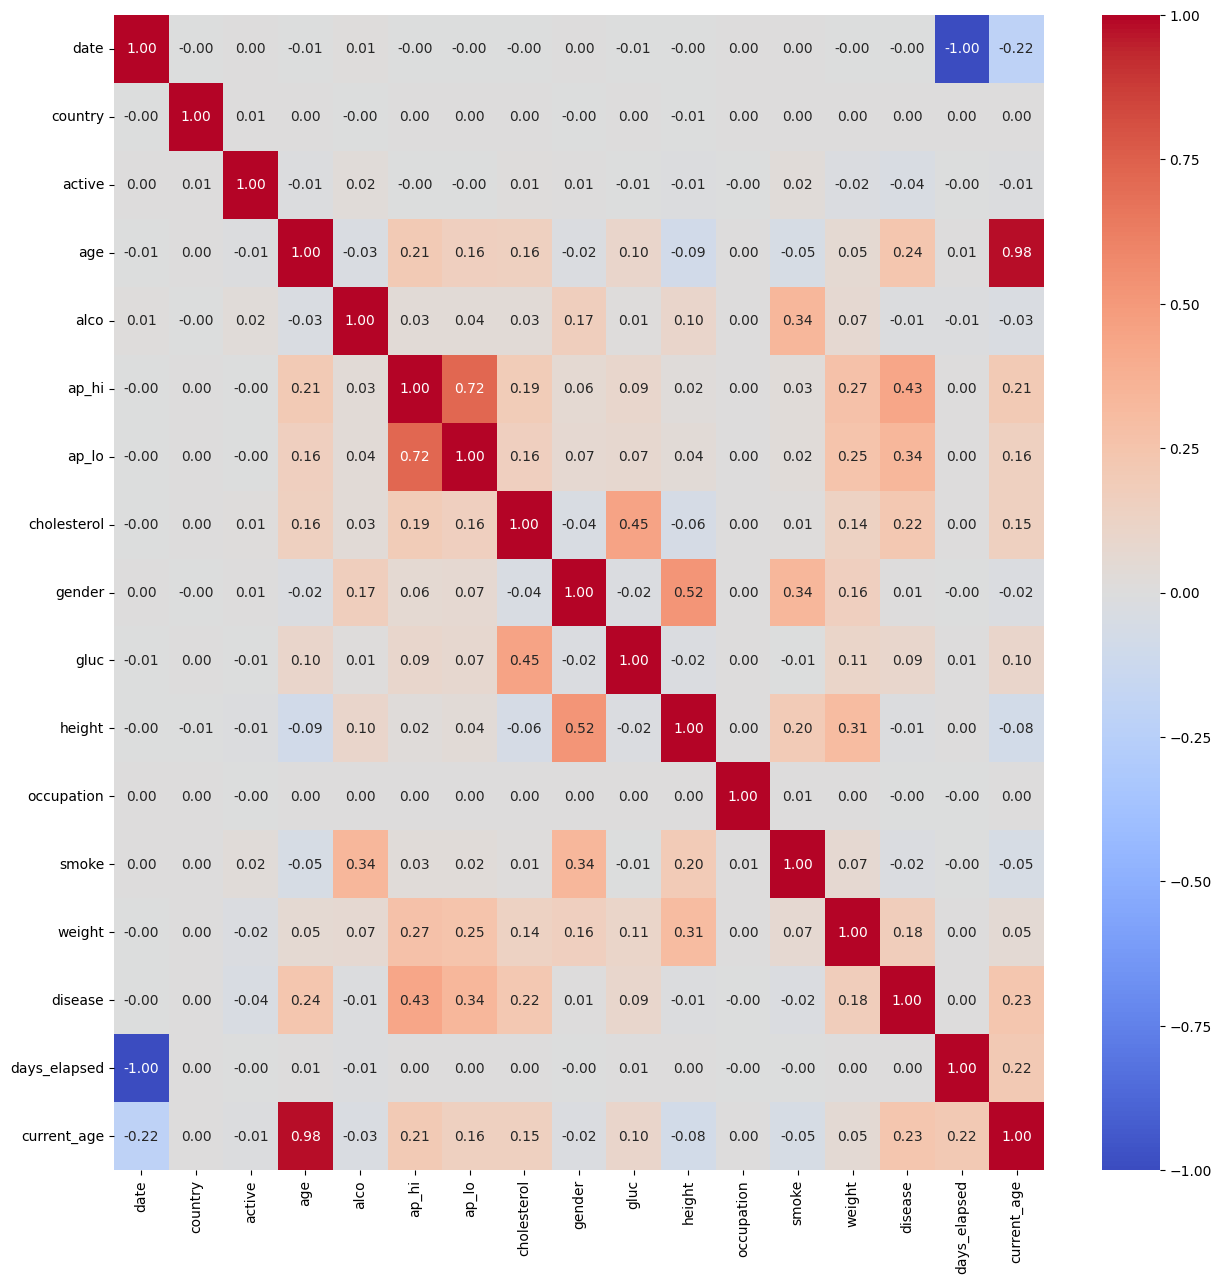

In [18]:
# PLot out the correlation matrix
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.fram

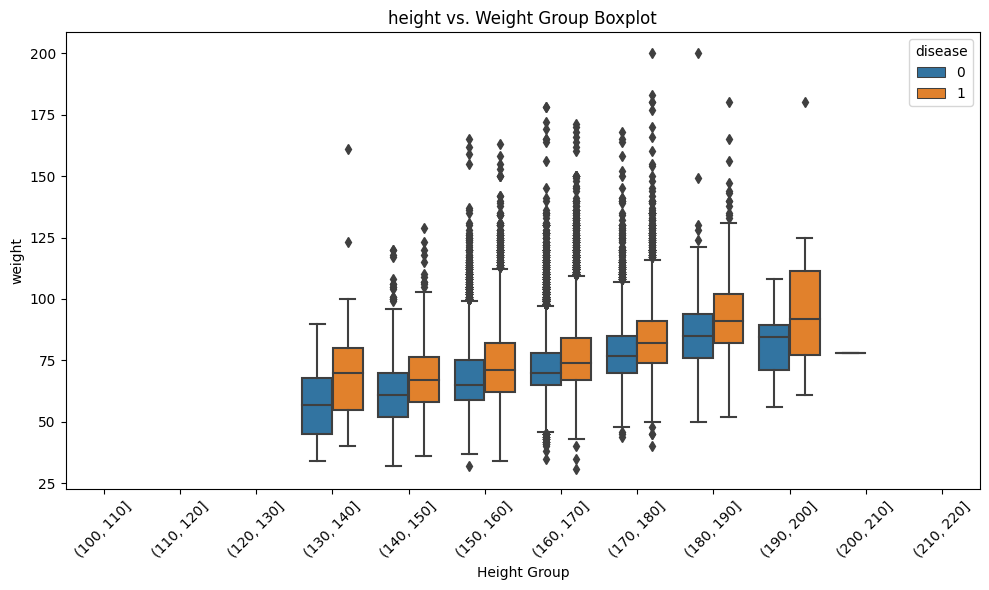

In [39]:
# Create bins for Height and Weight
height_bins = range(100, 230, 10)  # Create height bins from 150 to 220 in steps of 10
weight_bins = range(50, 200, 10)   # Create weight bins from 50 to 110 in steps of 10

# Group data into height and weight bins
df['Height Group'] = pd.cut(df['height'], bins=height_bins)
df['Weight Group'] = pd.cut(df['weight'], bins=weight_bins)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Height Group', y='weight', hue='disease', data=df)
plt.title('height vs. Weight Group Boxplot')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


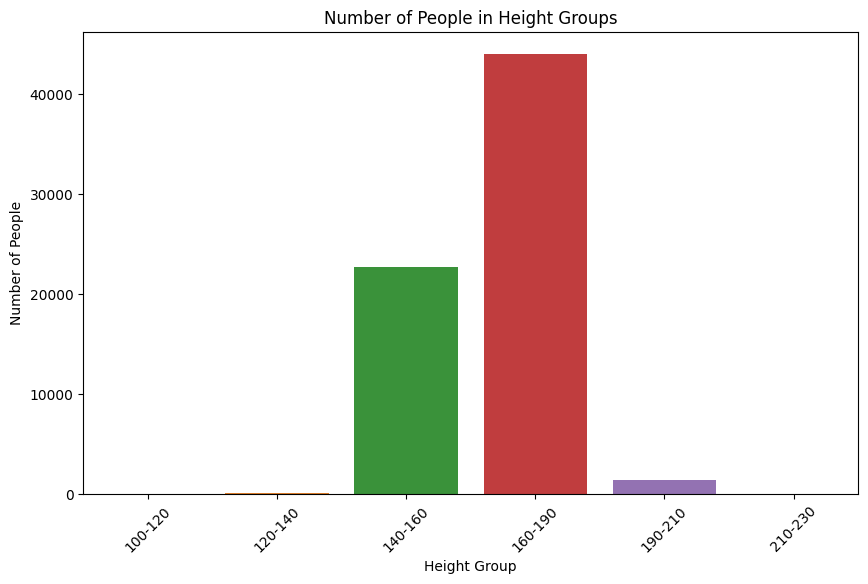

In [88]:

# Define the height bins and labels
height_bins = range(100, 230, 20) 
height_labels = ['100-120','120-140','140-160', '160-190', '190-210','210-230']

# Create a new column 'Height Group' with the assigned bins
df['Height Group'] = pd.cut(df['height'], bins=height_bins, labels=height_labels)

# Count the number of people in each height group
height_counts = df['Height Group'].value_counts().reset_index()
height_counts.columns = ['Height Group', 'Count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Height Group', y='Count', data=height_counts)
plt.xlabel('Height Group')
plt.ylabel('Number of People')
plt.title('Number of People in Height Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

/var/folders/68/jzqqm89x37v77phvst8pf_5r0000gn/T/ipykernel_32019/3495978771.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heart_disease_by_bp = df.groupby(['BloodPressureCategory', 'disease'])['ap_hi Group'].count().reset_index()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

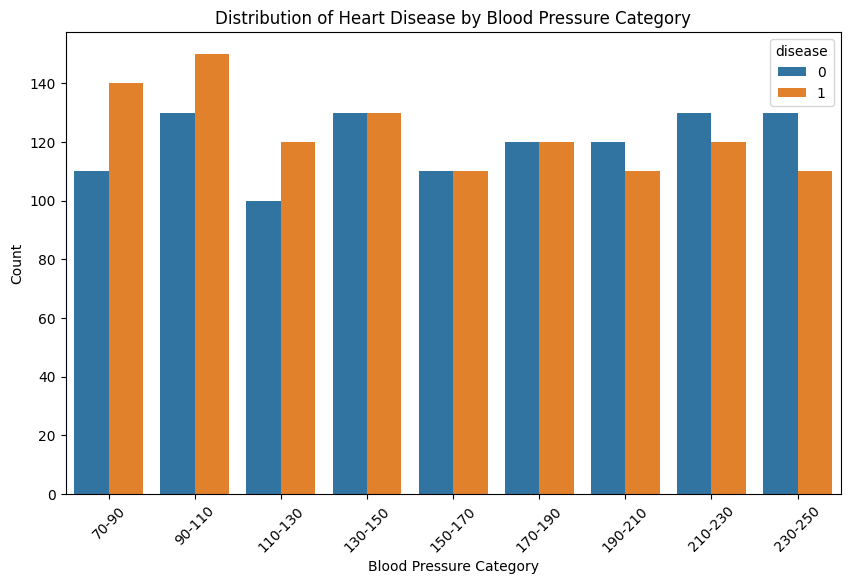

In [76]:
# Create bins for Height and Weight
ap_hi_bins = range(70, 240, 20)  # Create height bins from 70 to 220 in steps of 20
bins = [70, 90, 110, 130, 150, 170, 190, 210, 230, 250]  # Define your desired bin edges

# Group data into height and weight bins
df['ap_hi Group'] = pd.cut(df['ap_hi'], bins=height_bins)
df['BloodPressureCategory'] = pd.cut(df['ap_hi'], bins=bins, labels=['70-90', '90-110', '110-130', '130-150', '150-170', '170-190', '190-210', '210-230', '230-250'])

# Calculate the prevalence of heart disease in each blood pressure category
heart_disease_by_bp = df.groupby(['BloodPressureCategory', 'disease'])['ap_hi Group'].count().reset_index()
heart_disease_by_bp['Count_hi'] = df['ap_hi']

# Create a bar plot with hue
plt.figure(figsize=(10, 6))
sns.barplot(x='BloodPressureCategory', y='Count_hi', hue='disease', data=heart_disease_by_bp)
plt.xlabel('Blood Pressure Category')
plt.ylabel('Count')
plt.title('Distribution of Heart Disease by Blood Pressure Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

In [77]:
df['ap_lo'].describe()

count    68296.000000
mean        81.217568
std          9.087140
min         52.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        119.000000
Name: ap_lo, dtype: float64

/var/folders/68/jzqqm89x37v77phvst8pf_5r0000gn/T/ipykernel_32019/2855717194.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heart_disease_by_lo = df.groupby(['BloodPressureCategory_lo', 'disease'])['ap_lo Group'].count().reset_index()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

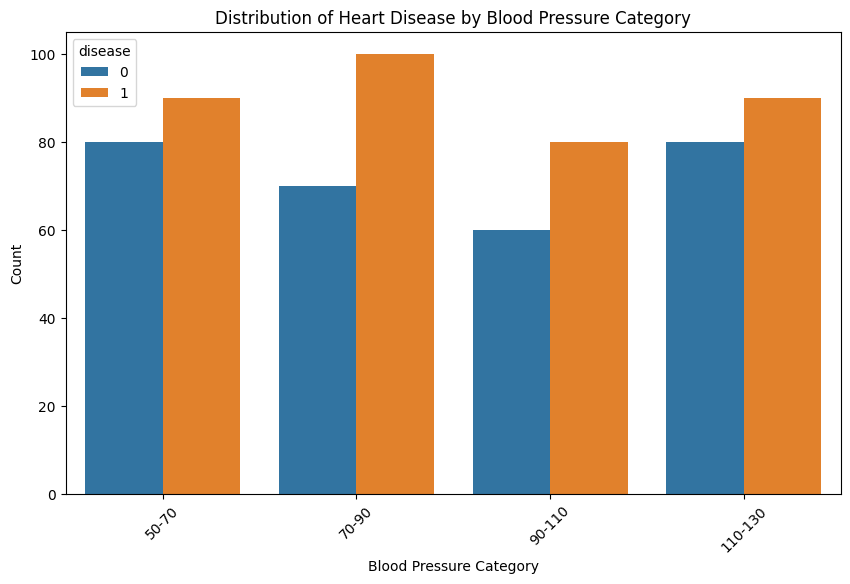

In [81]:
# Create bins for Height and Weight
bins = [50, 70, 90, 110, 130]  # Define your desired bin edges

# Group data into height and weight bins
df['ap_lo Group'] = pd.cut(df['ap_lo'], bins=height_bins)
df['BloodPressureCategory_lo'] = pd.cut(df['ap_lo'], bins=bins, labels=['50-70', '70-90', '90-110', '110-130'])

# Calculate the prevalence of heart disease in each blood pressure category
heart_disease_by_lo = df.groupby(['BloodPressureCategory_lo', 'disease'])['ap_lo Group'].count().reset_index()
heart_disease_by_lo['Count_lo'] = df['ap_lo']

# Create a bar plot with hue
plt.figure(figsize=(10, 6))
sns.barplot(x='BloodPressureCategory_lo', y='Count_lo', hue='disease', data=heart_disease_by_lo)
plt.xlabel('Blood Pressure Category')
plt.ylabel('Count')
plt.title('Distribution of Heart Disease by Blood Pressure Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


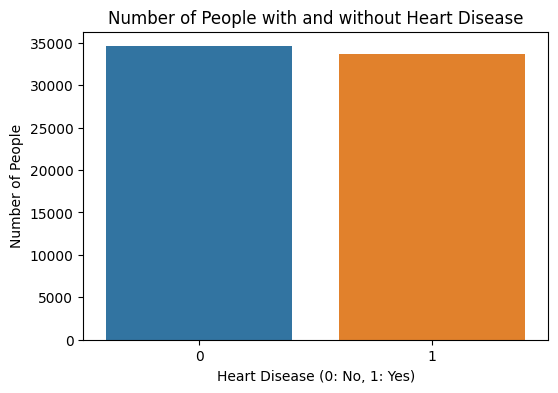

In [90]:
# Count the number of people with and without heart disease
heart_disease_counts = df['disease'].value_counts().reset_index()
heart_disease_counts.columns = ['disease', 'Count']

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='disease', y='Count', data=heart_disease_counts)
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Number of People')
plt.title('Number of People with and without Heart Disease')

plt.show()

## Findings:
The targetted column heart disease have high correlation with current age, weight, ap_hi, ap_lo, cholesterol, gluc

# Machine Learning
- Let's train a few suitable ML models to find the best prediction model

In [20]:
# Drop the unnecessary columns
df.drop(['date', 'days_elapsed', 'age'], axis=1, inplace=True)


# Set up for ML test train split
X = df.drop('disease', axis=1)
y = df['disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

In [21]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)  # You can adjust hyperparameters

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


In [22]:
# Create the Logistic Regression model
lr_model = LogisticRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# Create the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


In [24]:
# Create the K-NN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


In [82]:


# Define the height bins and labels
height_bins = range(100, 230, 20)
height_labels = ['100-130','130-150','150-170', '190-210', '210-230']

# Create a new column 'Height Group' with the assigned bins
df['Height Group'] = pd.cut(df['height'], bins=height_bins, labels=height_labels)

# Count the number of people in each height group
height_counts = df['Height Group'].value_counts().reset_index()
height_counts.columns = ['Height Group', 'Count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Height Group', y='Count', data=height_counts)
plt.xlabel('Height Group')
plt.ylabel('Number of People')
plt.title('Number of People in Height Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

ValueError: Bin labels must be one fewer than the number of bin edges